In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import frame_whitening as fw
import frame_whitening.data as fwd

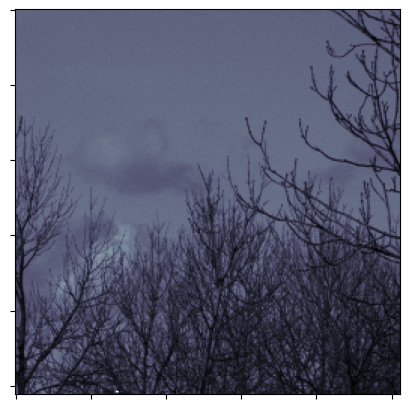

In [2]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 696969
rng = np.random.default_rng(seed)

n_images = 10
images = fwd.load_images(n_images=n_images, crop_size=256, rng=rng)

images = [img / np.max(img) for img in images]

img = images[4]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap="bone")
ax.set(xticklabels=[], yticklabels=[]);

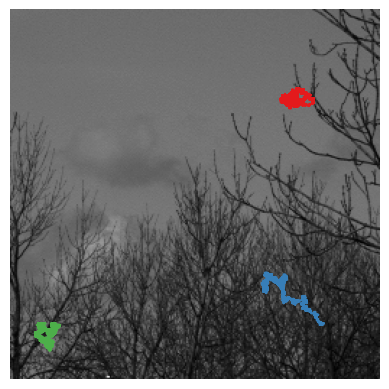

In [3]:
patch_h, patch_w = 16, 16
img_h, img_w = img.shape

sigma = .1
n_steps = 20_000

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img, cmap="gray")
# plt.colorbar(im)
ax.set(xticklabels=[], yticklabels=[])

n_contexts = 3
cols = sns.color_palette("Set1", n_contexts)

all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1, rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])
    ax.axis("off")

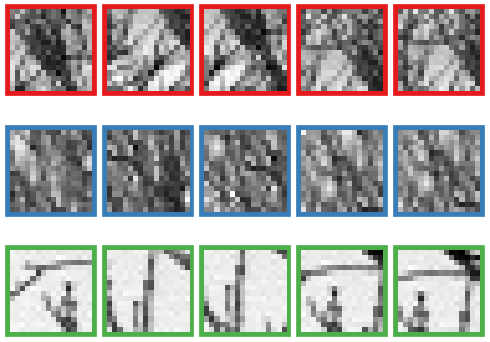

In [4]:
fwd.plot_context_samples(all_contexts, 5, "gray", "Set1", True);

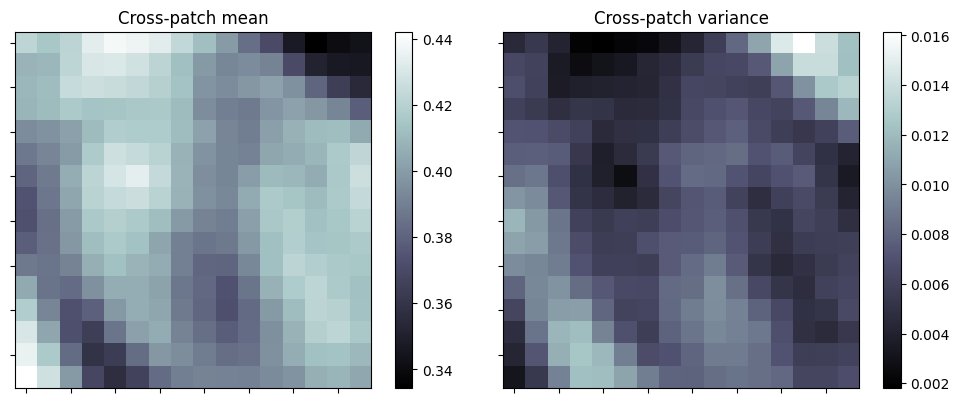

In [5]:
fwd.plot_patch_stats(all_contexts[2])

In [6]:
X = all_contexts[2]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 16

Cxx0 = np.cov(X0.T)
Cxx = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)

Mw = V @ np.diag(l12) @ V.T

(256, 5128)


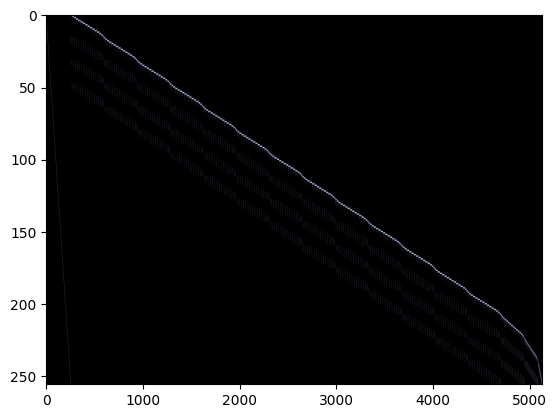

In [7]:
import frame_whitening.simulation_new as sim
n_batch = 2**11
conv_h, conv_w = 4, 4
W = fw.get_conv_frame(patch_h, patch_w, conv_h, conv_w)
print(W.shape)
plt.imshow(W, cmap="bone", aspect="auto")
step_skip = 100
g_last, g_all, errors, variances = sim.simulate(
                                        cholesky_list=[np.linalg.cholesky(Cxx)], 
                                        W=W, 
                                        batch_size=-1, 
                                        n_batch=n_batch, 
                                        lr_g=2E-2,
                                        g0=None, 
                                        online=False, 
                                        clamp=True,
                                        alpha=1.,
                                        save_every=step_skip,
                                    )

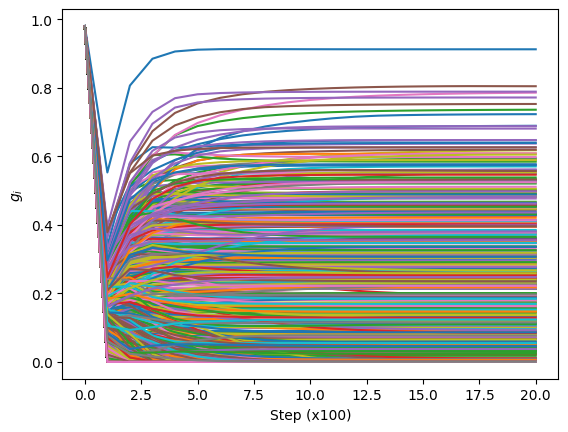

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(g_all)
ax.set(xlabel=f"Step (x{step_skip})", ylabel=r"$g_i$");

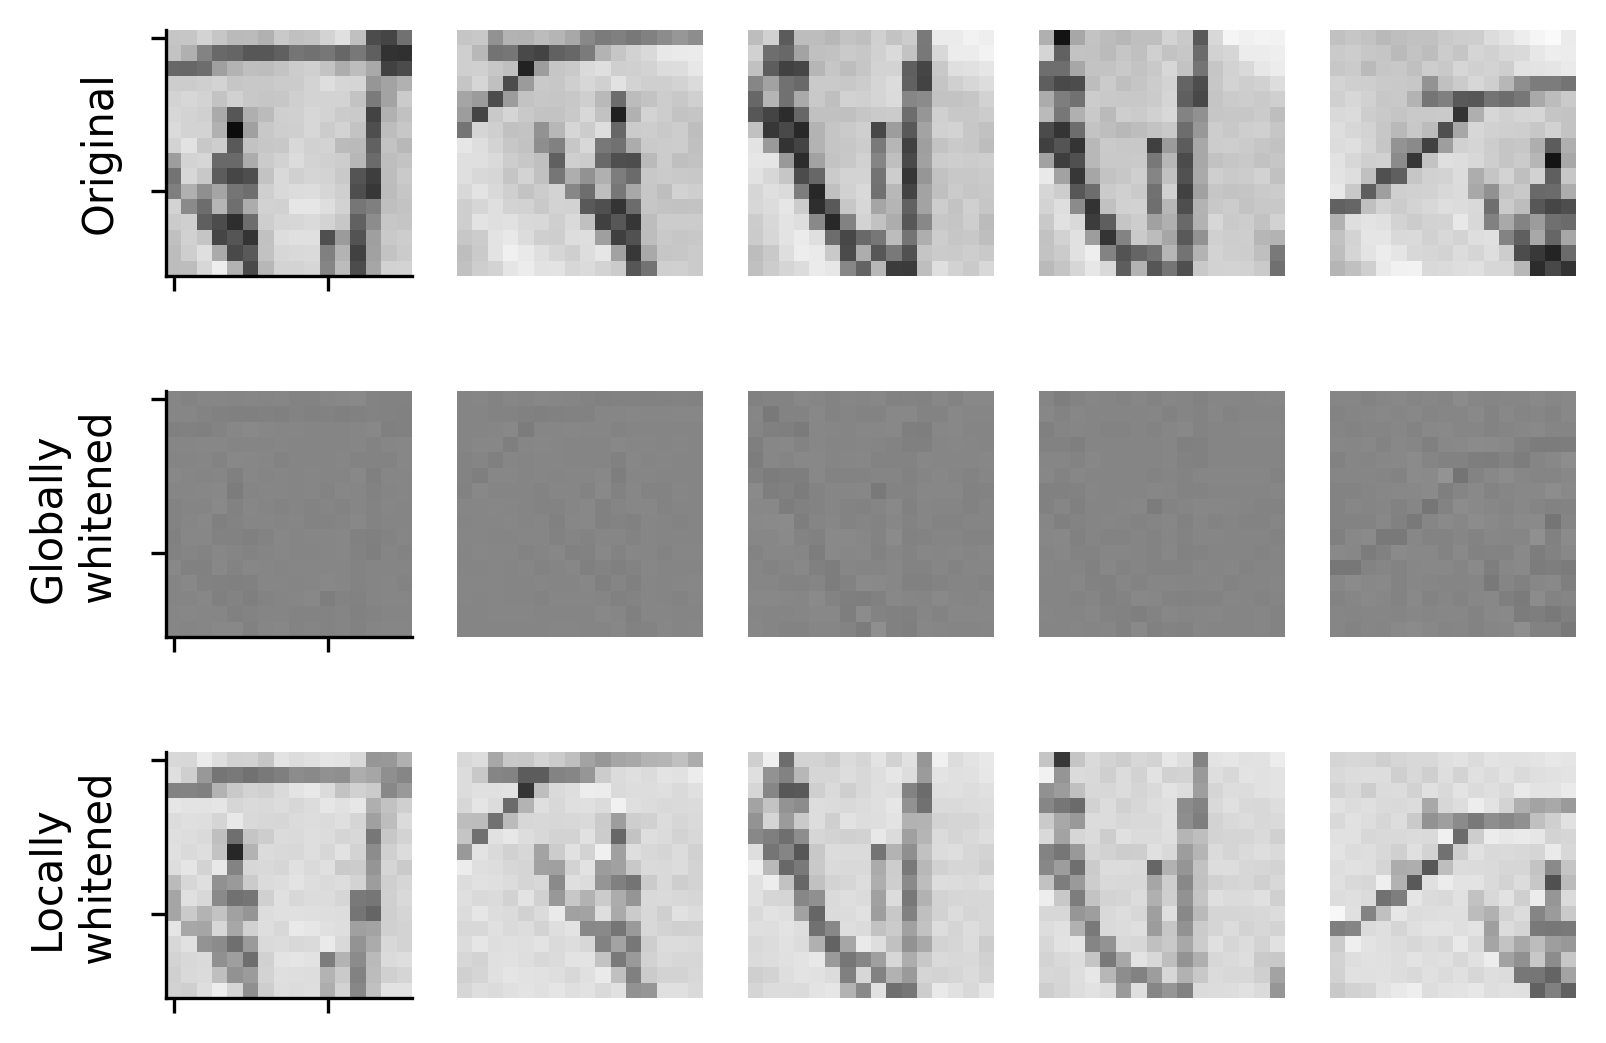

In [9]:
WGW = W @ (g_last[0][:,None] * W.T)
Ixx = np.eye(patch_h * patch_w)
M = np.linalg.inv(Ixx + WGW)
Xw2 = X0 @ M.T

Xw = X0 @ Mw.T

X00 = X0.reshape(n_steps, patch_h, patch_w)
Xw = Xw.reshape(n_steps, patch_h, patch_w)
Xw2 = Xw2.reshape(n_steps, patch_h, patch_w)

fig, ax = fwd.plot_context_samples(np.stack([X00, Xw, Xw2], 0), 5, "gray", "Set1", False, dpi=300)
ax[0,0].axis("on")
ax[1,0].axis("on")
ax[2,0].axis("on")

ax[0,0].set(xticklabels=[], yticklabels=[], ylabel="Original")
ax[1,0].set(xticklabels=[], yticklabels=[], ylabel="Globally \n whitened")
ax[2,0].set(xticklabels=[], yticklabels=[], ylabel="Locally \n whitened")
sns.despine()

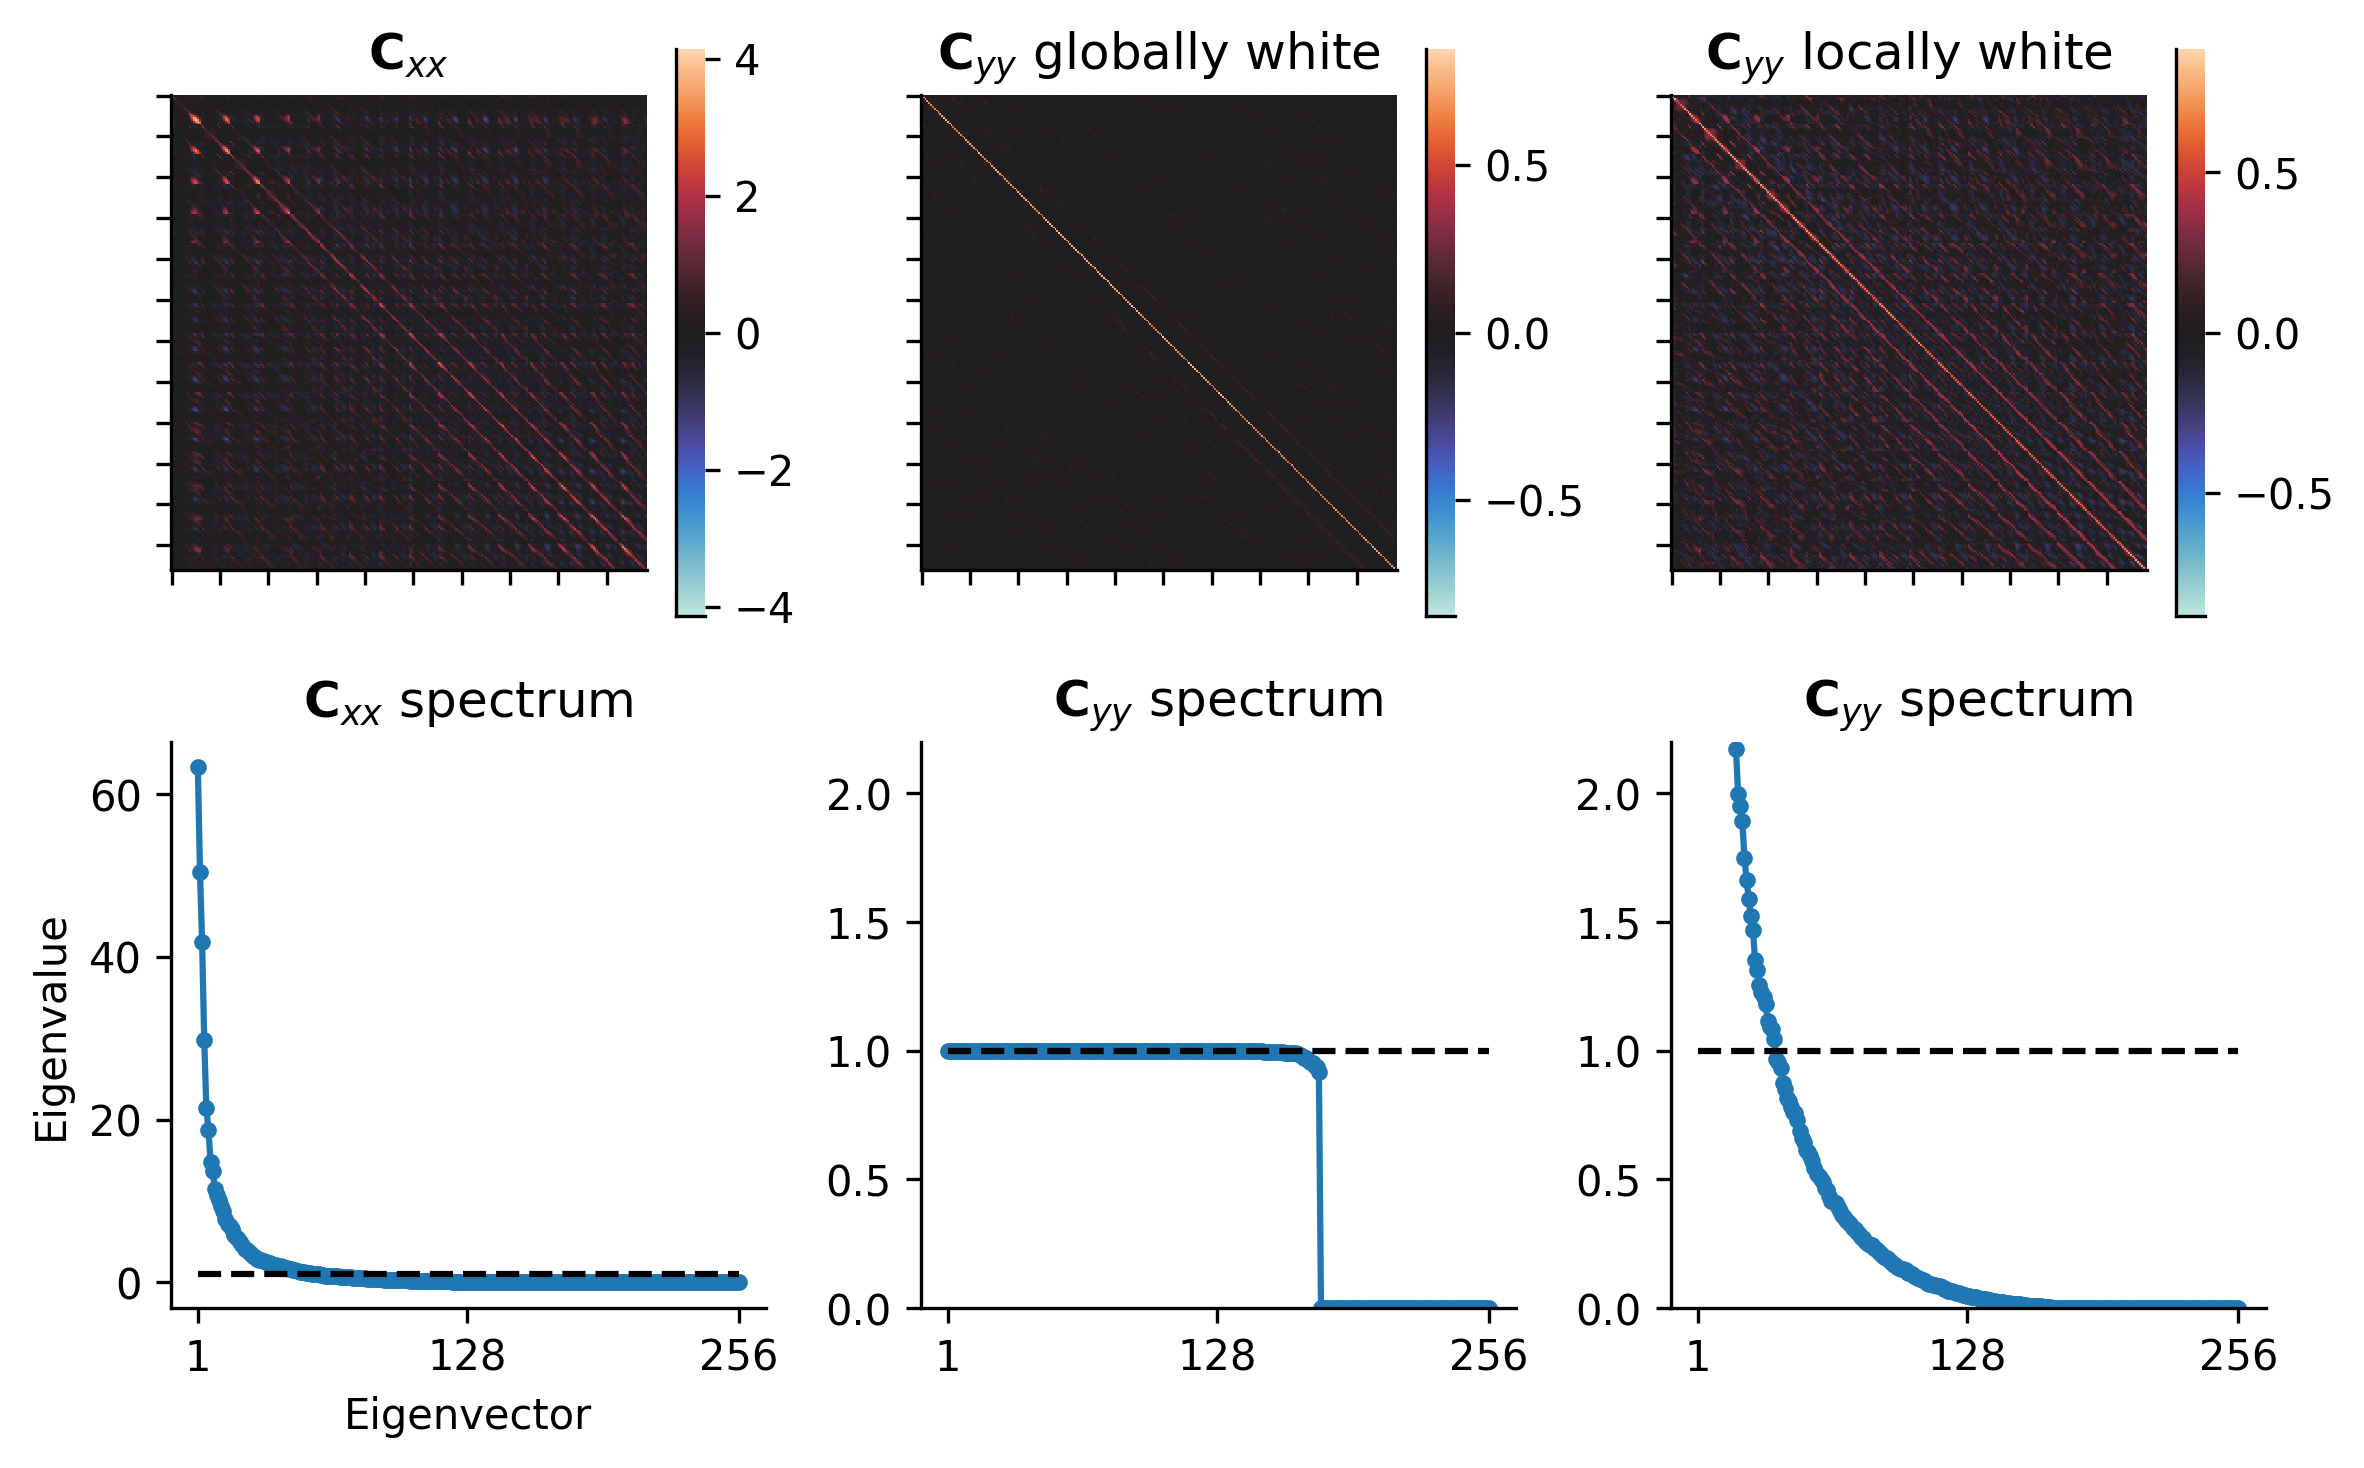

In [16]:
Cw2 = np.cov(Xw2.reshape(n_steps, -1).T)

vv, _ = np.linalg.eigh(Cw2)
Cww = Mw @ Cxx0 @ Mw.T

def heatmap(C, ax):
    _VMAX = np.max(np.abs(C)) 
    im =sns.heatmap(C, ax=ax, vmin=-_VMAX, vmax=_VMAX, cmap="icefire", cbar=True, square=True)


fig, ax = plt.subplots(2, 3, figsize=(8, 5), dpi=300, sharex="row")
N = Cxx0.shape[0]

heatmap(Cxx0, ax[0,0])
heatmap(Cww, ax[0,1])
heatmap(Cw2, ax[0,2])

ax[1,0].plot(np.arange(1,N+1), np.linalg.eigh(Cxx0)[0][::-1], ".-")
ax[1,1].plot(np.arange(1, N+1), np.linalg.eigh(Cww)[0][::-1], ".-")
ax[1,2].plot(np.arange(1, N+1), np.linalg.eigh(Cw2)[0][::-1], ".-")

ax[1,0].hlines(1, 1, N, color="k", linestyle="--")
ax[1,1].hlines(1, 1, N, color="k", linestyle="--")
ax[1,2].hlines(1, 1, N, color="k", linestyle="--")


ax[0,0].set(title=r"${\bf C}_{xx}$", xticklabels=[], yticklabels=[])
ax[0,1].set(title=r"${\bf C}_{yy}$ globally white", xticklabels=[], yticklabels=[])
ax[0,2].set(title=r"${\bf C}_{yy}$ locally white", xticklabels=[], yticklabels=[])

yscale = "linear"
ax[1, 0].set(title=r"${\bf C}_{xx}$ spectrum", yscale=yscale, 
    ylabel="Eigenvalue", xlabel="Eigenvector",
    xticks=(1, N//2, N), xticklabels=(1, N//2, N))

ax[1, 1].set(title=r"${\bf C}_{yy}$ spectrum", yscale=yscale, ylim=(0, 2.2))
ax[1, 2].set(title=r"${\bf C}_{yy}$ spectrum", yscale=yscale, ylim=(0, 2.2))

fig.tight_layout()
sns.despine()